# 第09章: 09 Mlp Regression Waveforms

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] この章の内容を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Python基礎

⏱️ **推定学習時間**: 60-90分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: 機械学習

---


## 💡 イントロダクション：なぜこれを学ぶのか？

### モチベーション

[この章の重要性を説明]

### 実世界での応用

[具体的な応用例]

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: Generate Complex Waveforms

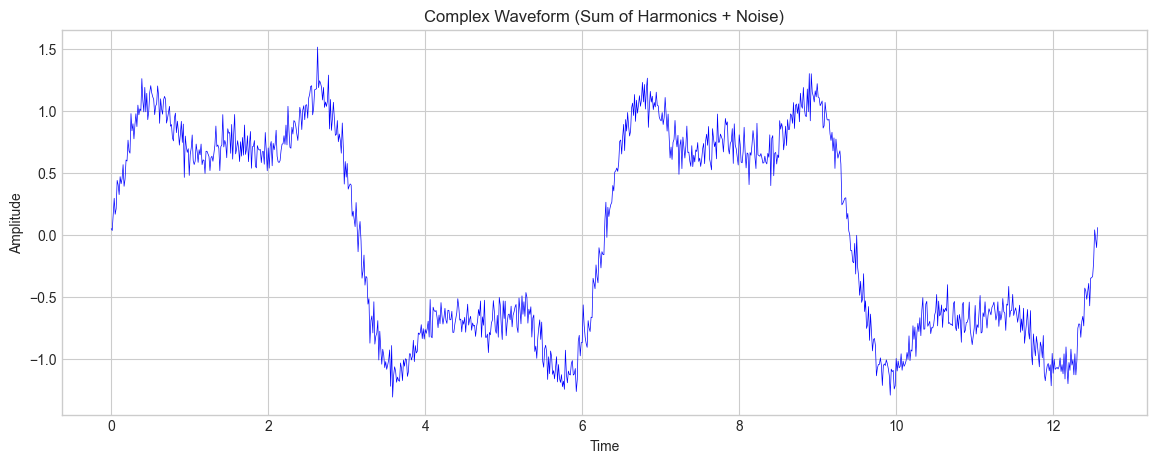

Waveform length: 1000 points
Value range: [-1.31, 1.51]


In [2]:
def generate_complex_waveform(n_points=1000, noise_level=0.1):
    """
    Generate a complex waveform with multiple harmonics.
    y = sin(t) + 0.5*sin(3t) + 0.25*sin(5t) + noise
    """
    t = np.linspace(0, 4 * np.pi, n_points)
    
    # Base signal with harmonics
    y = (np.sin(t) + 
         0.5 * np.sin(3 * t) + 
         0.25 * np.sin(5 * t))
    
    # Add noise
    y += noise_level * np.random.randn(n_points)
    
    return t, y

# Generate waveform
t, y = generate_complex_waveform(n_points=1000, noise_level=0.1)

# Visualize
plt.figure(figsize=(14, 5))
plt.plot(t, y, 'b-', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Complex Waveform (Sum of Harmonics + Noise)')
plt.grid(True)
plt.show()

print(f"Waveform length: {len(y)} points")
print(f"Value range: [{y.min():.2f}, {y.max():.2f}]")

## Part 2: Create Features for Time Series Prediction

In [3]:
# ============================================================
# [コードの説明]
# ============================================================

def create_lag_features(y, n_lags=10):
    """
    Create lagged features for time series prediction.
    X[i] = [y[i-n_lags], y[i-n_lags+1], ..., y[i-1]]
    y_target[i] = y[i]
    """
    X = []
    y_target = []
    
    for i in range(n_lags, len(y)):
        X.append(y[i-n_lags:i])
        y_target.append(y[i])
    
    return np.array(X), np.array(y_target)

# Create features
n_lags = 20
X, y_target = create_lag_features(y, n_lags=n_lags)

print(f"Feature shape: {X.shape}")
print(f"Target shape: {y_target.shape}")
print(f"\nEach sample uses {n_lags} previous time points to predict the next value.")

Feature shape: (980, 20)
Target shape: (980,)

Each sample uses 20 previous time points to predict the next value.


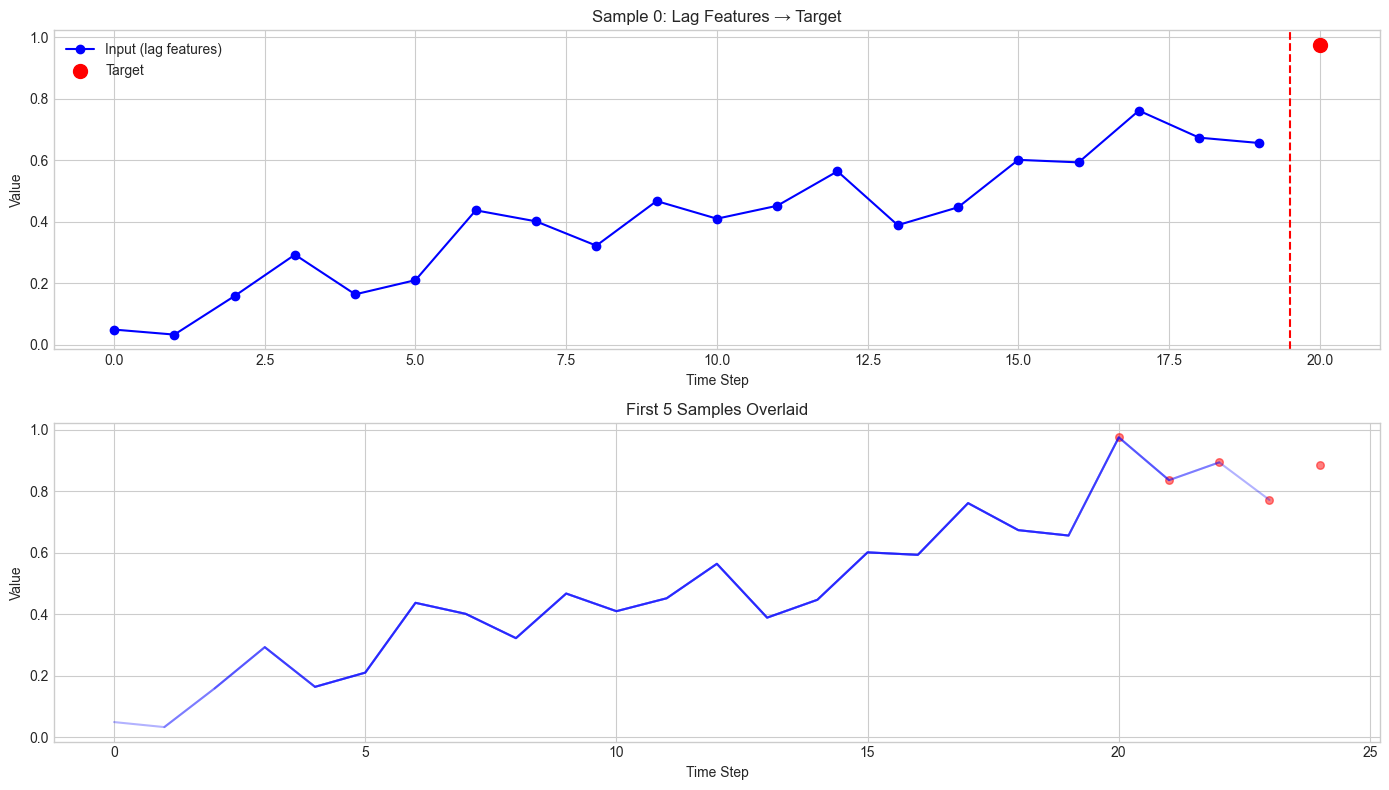

In [4]:
# Visualize lag features
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Show first few samples
sample_idx = 0
axes[0].plot(range(n_lags), X[sample_idx], 'bo-', label='Input (lag features)')
axes[0].axvline(x=n_lags-0.5, color='r', linestyle='--')
axes[0].scatter([n_lags], [y_target[sample_idx]], c='r', s=100, zorder=5, label='Target')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Value')
axes[0].set_title(f'Sample {sample_idx}: Lag Features → Target')
axes[0].legend()

# Show multiple samples
for i in range(0, min(5, len(X))):
    axes[1].plot(range(i, i + n_lags), X[i], 'b-', alpha=0.3)
    axes[1].scatter([i + n_lags], [y_target[i]], c='r', s=30, alpha=0.5)

axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Value')
axes[1].set_title('First 5 Samples Overlaid')

plt.tight_layout()
plt.show()

## Part 3: Train MLP Regressor

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, shuffle=False  # Keep temporal order
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 784
Test samples: 196


In [6]:
# Train MLP Regressor
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

# Predict
y_pred_train = mlp.predict(X_train_scaled)
y_pred_test = mlp.predict(X_test_scaled)

# Metrics
print("Model Performance:")
print("="*50)
print(f"Training R²: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"\nIterations: {mlp.n_iter_}")

Model Performance:
Training R²: 0.9816
Test R²: 0.7594
Test RMSE: 0.1105
Test MAE: 0.0883

Iterations: 51


## Part 4: Visualize Waveform Prediction

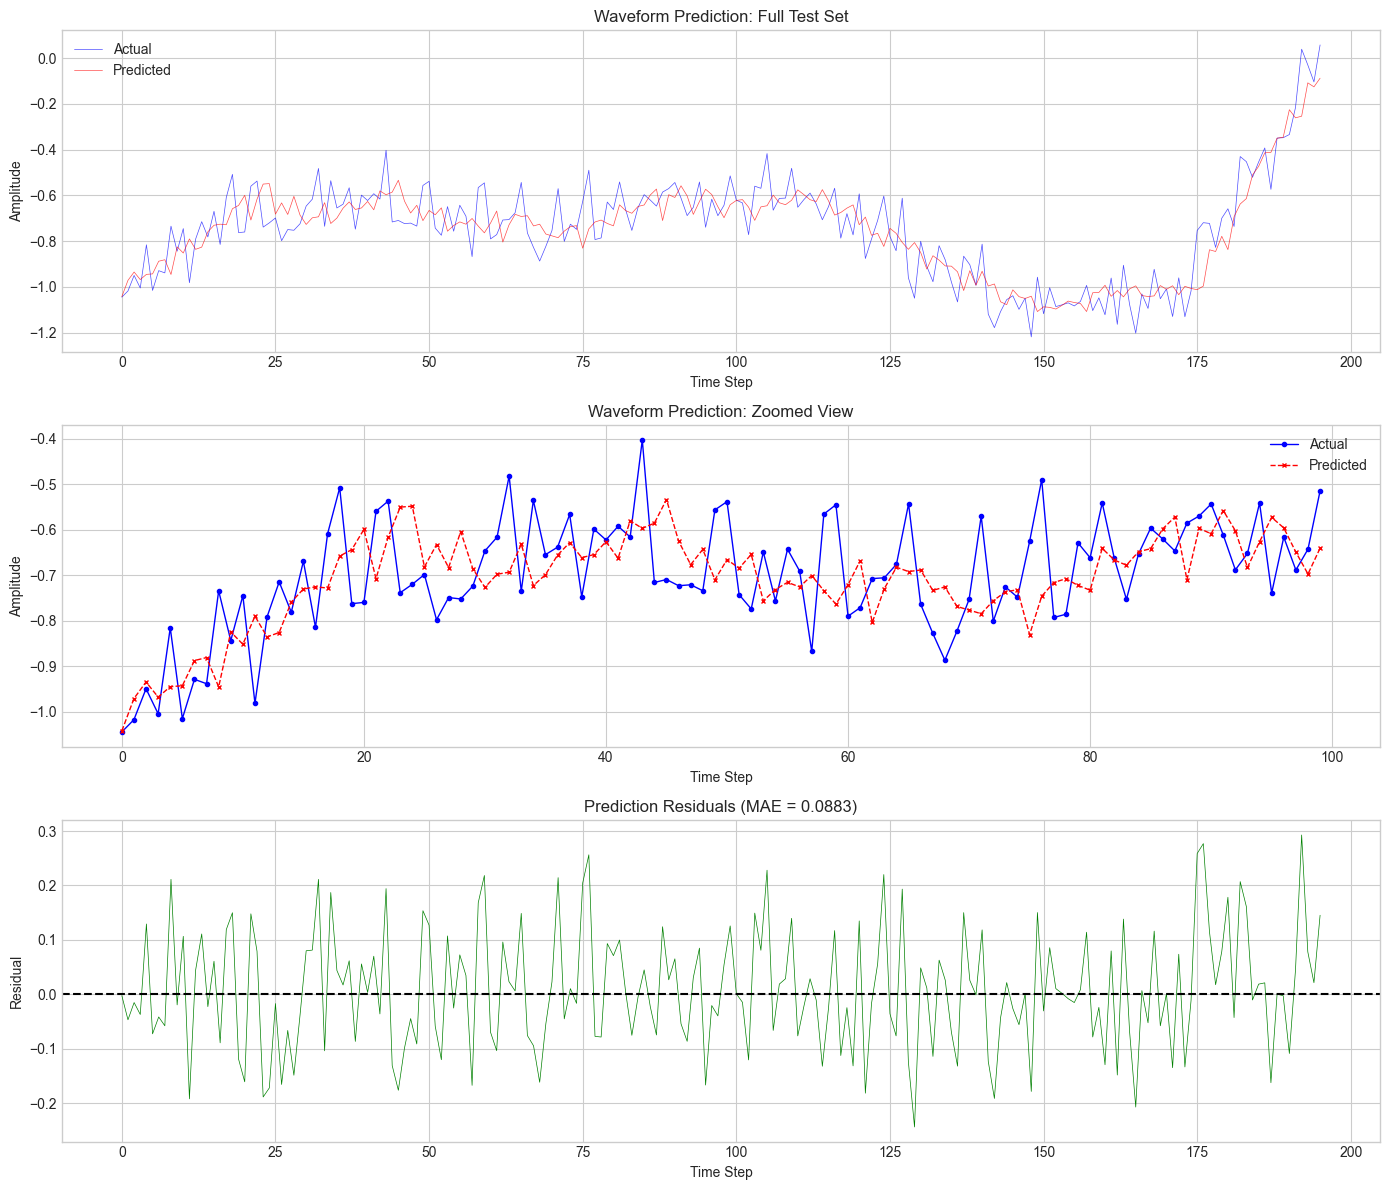

In [7]:
# Plot predicted vs actual waveform
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Full waveform comparison
axes[0].plot(y_test, 'b-', linewidth=0.5, label='Actual', alpha=0.7)
axes[0].plot(y_pred_test, 'r-', linewidth=0.5, label='Predicted', alpha=0.7)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Waveform Prediction: Full Test Set')
axes[0].legend()

# Zoomed view
zoom_start, zoom_end = 0, 100
axes[1].plot(range(zoom_start, zoom_end), y_test[zoom_start:zoom_end], 'b-', 
             linewidth=1, label='Actual', marker='o', markersize=3)
axes[1].plot(range(zoom_start, zoom_end), y_pred_test[zoom_start:zoom_end], 'r--', 
             linewidth=1, label='Predicted', marker='x', markersize=3)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Waveform Prediction: Zoomed View')
axes[1].legend()

# Residuals
residuals = y_test - y_pred_test
axes[2].plot(residuals, 'g-', linewidth=0.5)
axes[2].axhline(y=0, color='k', linestyle='--')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Residual')
axes[2].set_title(f'Prediction Residuals (MAE = {mean_absolute_error(y_test, y_pred_test):.4f})')

plt.tight_layout()
plt.show()

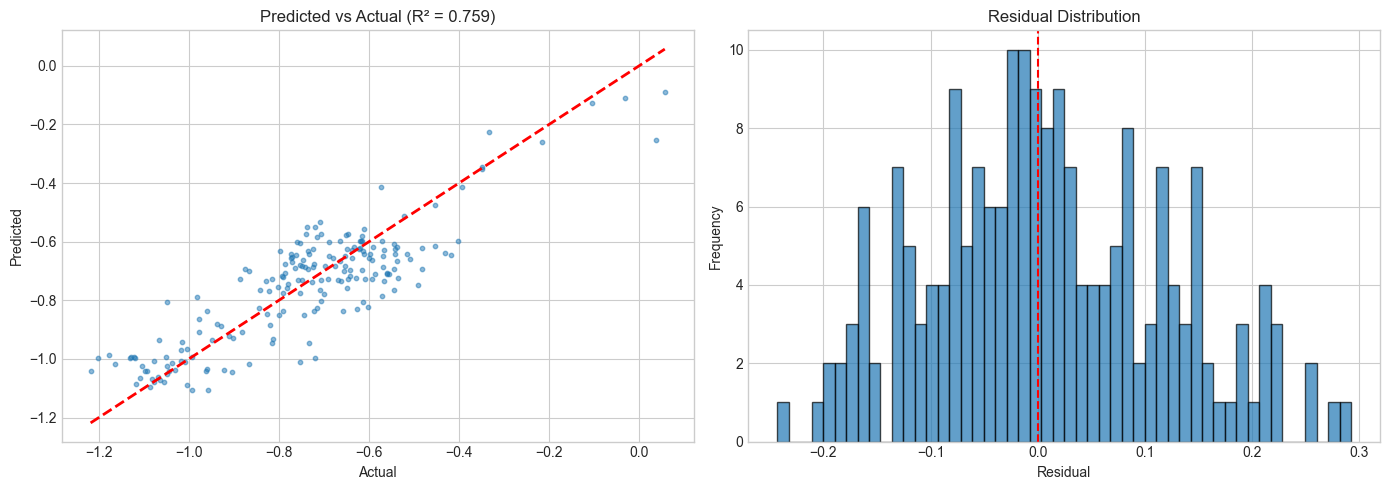

In [8]:
# ============================================================
# [コードの説明]
# ============================================================

# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_pred_test, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Predicted vs Actual (R² = {r2_score(y_test, y_pred_test):.3f})')

# Residual distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

## Part 5: Effect of Number of Lags

In [9]:
# Test different number of lags
lag_values = [5, 10, 20, 30, 50]

results = []

for n_lags in lag_values:
    # Create features
    X_lag, y_lag = create_lag_features(y, n_lags=n_lags)
    
    # Split
    X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
        X_lag, y_lag, test_size=0.2, shuffle=False
    )
    
    # Scale
    scaler_lag = StandardScaler()
    X_train_lag_scaled = scaler_lag.fit_transform(X_train_lag)
    X_test_lag_scaled = scaler_lag.transform(X_test_lag)
    
    # Train
    mlp_lag = MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    mlp_lag.fit(X_train_lag_scaled, y_train_lag)
    
    # Evaluate
    y_pred_lag = mlp_lag.predict(X_test_lag_scaled)
    
    results.append({
        'n_lags': n_lags,
        'r2': r2_score(y_test_lag, y_pred_lag),
        'rmse': np.sqrt(mean_squared_error(y_test_lag, y_pred_lag)),
        'mae': mean_absolute_error(y_test_lag, y_pred_lag)
    })

df_lags = pd.DataFrame(results)
print("Effect of Number of Lags:")
print(df_lags.to_string(index=False))

Effect of Number of Lags:
 n_lags       r2     rmse      mae
      5 0.745908 0.114382 0.092167
     10 0.739797 0.115366 0.093922
     20 0.759363 0.110547 0.088322
     30 0.745405 0.113334 0.093298
     50 0.703690 0.122303 0.096661


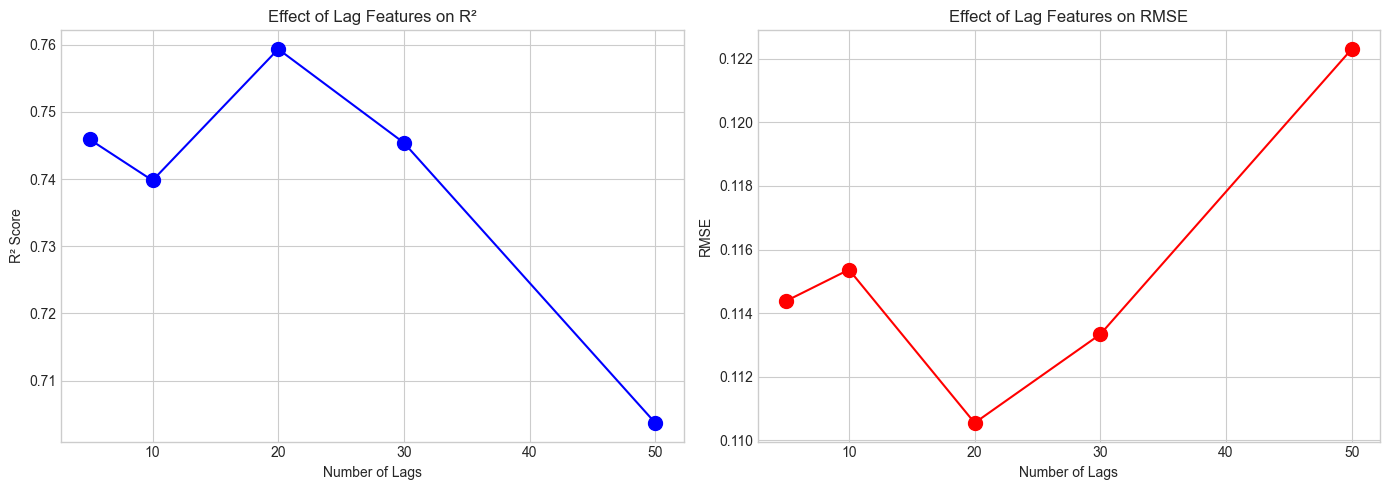

In [10]:
# ============================================================
# [コードの説明]
# ============================================================

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(df_lags['n_lags'], df_lags['r2'], 'bo-', markersize=10)
axes[0].set_xlabel('Number of Lags')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Effect of Lag Features on R²')
axes[0].grid(True)

axes[1].plot(df_lags['n_lags'], df_lags['rmse'], 'ro-', markersize=10)
axes[1].set_xlabel('Number of Lags')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Effect of Lag Features on RMSE')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Part 6: Architecture Search for Waveform Prediction

In [11]:
# Use optimal number of lags
best_n_lags = df_lags.loc[df_lags['r2'].idxmax(), 'n_lags']
print(f"Using optimal n_lags: {best_n_lags}")

# Create features
X, y_target = create_lag_features(y, n_lags=int(best_n_lags))
X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, shuffle=False
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Test architectures
architectures = [
    (50,), (100,), (200,),
    (100, 50), (200, 100),
    (100, 50, 25), (200, 100, 50)
]

arch_results = []

for arch in architectures:
    mlp = MLPRegressor(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    
    y_pred = mlp.predict(X_test_scaled)
    
    arch_results.append({
        'architecture': str(arch),
        'r2': r2_score(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'n_iter': mlp.n_iter_
    })

df_arch = pd.DataFrame(arch_results).sort_values('r2', ascending=False)
print("\nArchitecture Comparison:")
print(df_arch.to_string(index=False))

Using optimal n_lags: 20

Architecture Comparison:
  architecture       r2     rmse  n_iter
(200, 100, 50) 0.778006 0.106178      34
    (200, 100) 0.768958 0.108321      48
        (200,) 0.764928 0.109261      65
 (100, 50, 25) 0.759973 0.110407      51
     (100, 50) 0.759363 0.110547      51
        (100,) 0.734668 0.116081      93
         (50,) 0.721645 0.118895     113


## Part 7: GridSearchCV for Waveform Prediction

In [12]:
# ============================================================
# [コードの説明]
# ============================================================

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (100, 50), (200, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp = MLPRegressor(
    activation='relu',
    solver='adam',
    max_iter=500,
    early_stopping=True,
    random_state=42
)

grid_search = GridSearchCV(
    mlp, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=MLPRegressor(early_stopping=True, max_iter=500,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (200,), (100, 50),
                                                (200, 100)],
                         'learning_rate_init': [0.001, 0.01]},
             scoring='r2', verbose=1)

In [13]:
# ============================================================
# [コードの説明]
# ============================================================

# Best parameters
print("Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV R²: {grid_search.best_score_:.4f}")

# Test with best model
y_pred_best = grid_search.predict(X_test_scaled)
print(f"Test R²: {r2_score(y_test, y_pred_best):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_best)):.4f}")

Best Parameters:
  alpha: 0.001
  hidden_layer_sizes: (200, 100)
  learning_rate_init: 0.01

Best CV R²: 0.9633
Test R²: 0.7471
Test RMSE: 0.1133


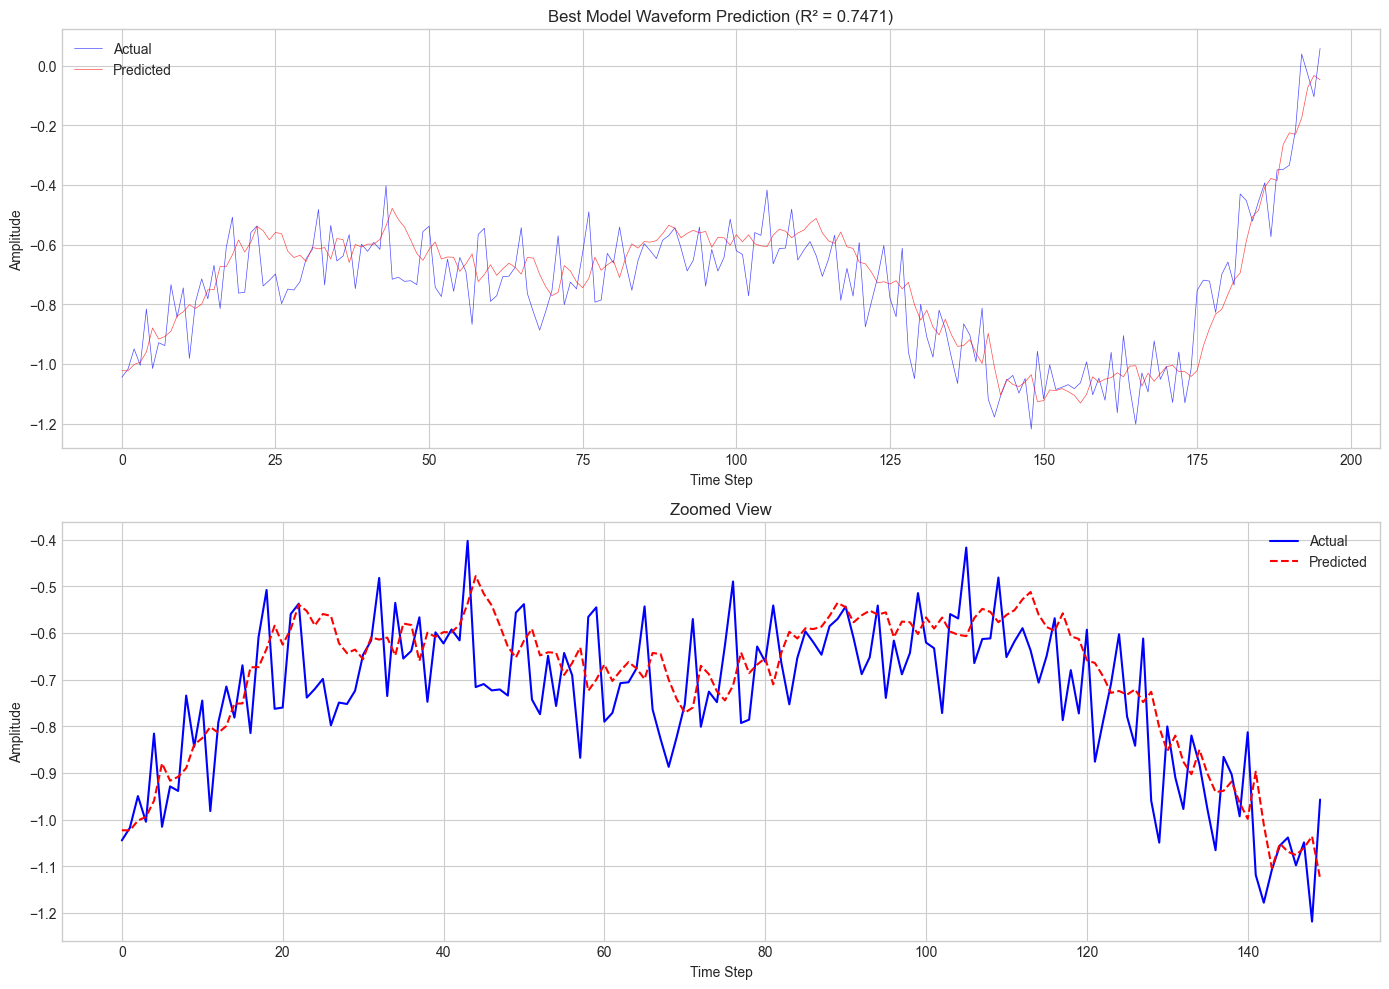

In [14]:
# Visualize best model predictions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full prediction
axes[0].plot(y_test, 'b-', linewidth=0.5, label='Actual', alpha=0.7)
axes[0].plot(y_pred_best, 'r-', linewidth=0.5, label='Predicted', alpha=0.7)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Best Model Waveform Prediction (R² = {r2_score(y_test, y_pred_best):.4f})')
axes[0].legend()

# Zoomed view
zoom_range = slice(0, 150)
axes[1].plot(y_test[zoom_range], 'b-', linewidth=1.5, label='Actual')
axes[1].plot(y_pred_best[zoom_range], 'r--', linewidth=1.5, label='Predicted')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Zoomed View')
axes[1].legend()

plt.tight_layout()
plt.show()

## Part 8: Different Waveform Types

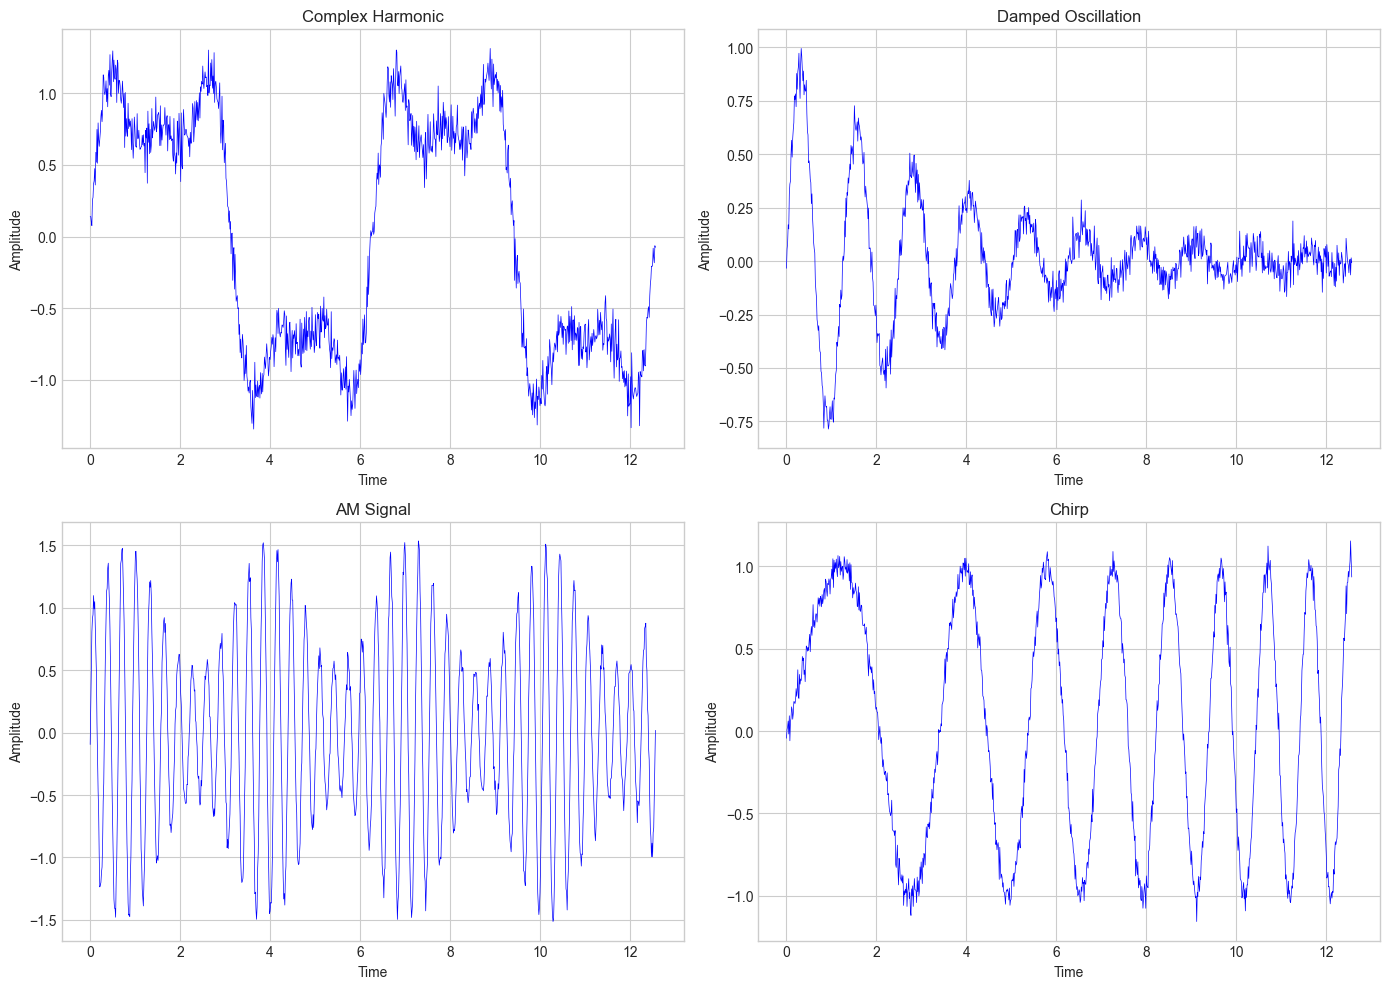

In [15]:
def generate_damped_oscillation(n_points=1000, damping=0.3, noise=0.05):
    t = np.linspace(0, 4 * np.pi, n_points)
    y = np.exp(-damping * t) * np.sin(5 * t)
    y += noise * np.random.randn(n_points)
    return t, y

def generate_am_signal(n_points=1000, carrier_freq=20, mod_freq=2, noise=0.05):
    t = np.linspace(0, 4 * np.pi, n_points)
    carrier = np.sin(carrier_freq * t)
    modulator = 1 + 0.5 * np.sin(mod_freq * t)
    y = carrier * modulator
    y += noise * np.random.randn(n_points)
    return t, y

def generate_chirp(n_points=1000, noise=0.05):
    t = np.linspace(0, 4 * np.pi, n_points)
    # Frequency increases with time
    y = np.sin(t * (1 + t/4))
    y += noise * np.random.randn(n_points)
    return t, y

# Generate all waveforms
waveforms = {
    'Complex Harmonic': generate_complex_waveform(1000, 0.1),
    'Damped Oscillation': generate_damped_oscillation(1000, 0.3, 0.05),
    'AM Signal': generate_am_signal(1000, 20, 2, 0.05),
    'Chirp': generate_chirp(1000, 0.05)
}

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, (t, y)) in enumerate(waveforms.items()):
    axes[idx].plot(t, y, 'b-', linewidth=0.5)
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()

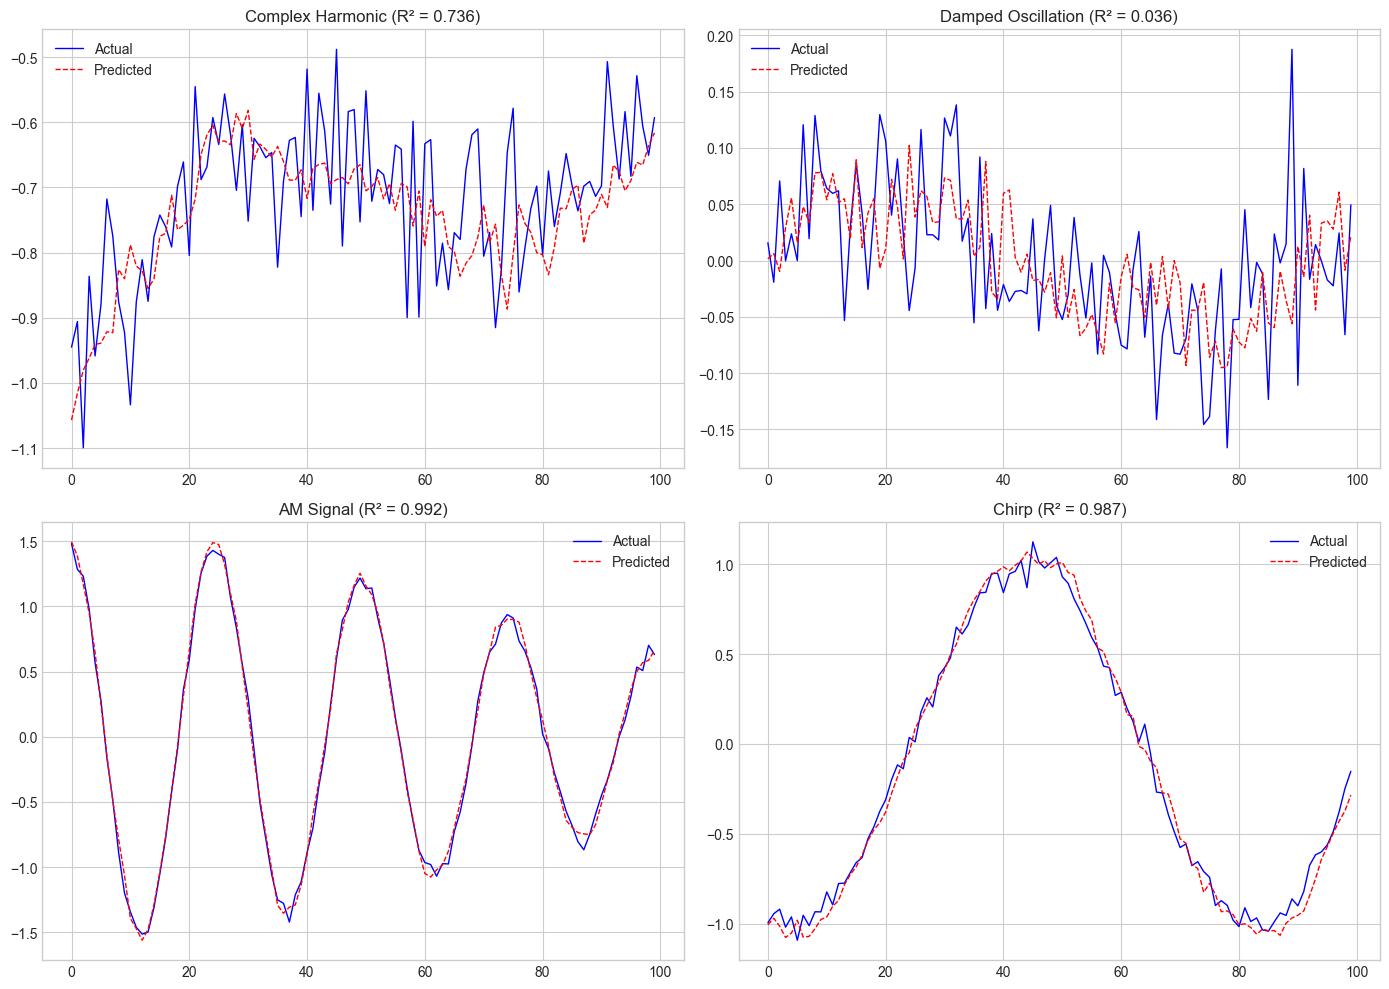


Waveform Prediction Results:
          Waveform       R²     RMSE
  Complex Harmonic 0.735734 0.114683
Damped Oscillation 0.035579 0.060231
         AM Signal 0.992302 0.060966
             Chirp 0.987328 0.081835


In [16]:
# Train models for each waveform type
n_lags = 30

waveform_results = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, (t, y_wave)) in enumerate(waveforms.items()):
    # Create features
    X, y_target = create_lag_features(y_wave, n_lags=n_lags)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_target, test_size=0.2, shuffle=False
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train
    mlp = MLPRegressor(
        hidden_layer_sizes=(200, 100),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = mlp.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    
    waveform_results.append({
        'Waveform': name,
        'R²': r2,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })
    
    # Plot
    axes[idx].plot(y_test[:100], 'b-', linewidth=1, label='Actual')
    axes[idx].plot(y_pred[:100], 'r--', linewidth=1, label='Predicted')
    axes[idx].set_title(f'{name} (R² = {r2:.3f})')
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("\nWaveform Prediction Results:")
print(pd.DataFrame(waveform_results).to_string(index=False))

## Part 9: Multi-Step Prediction

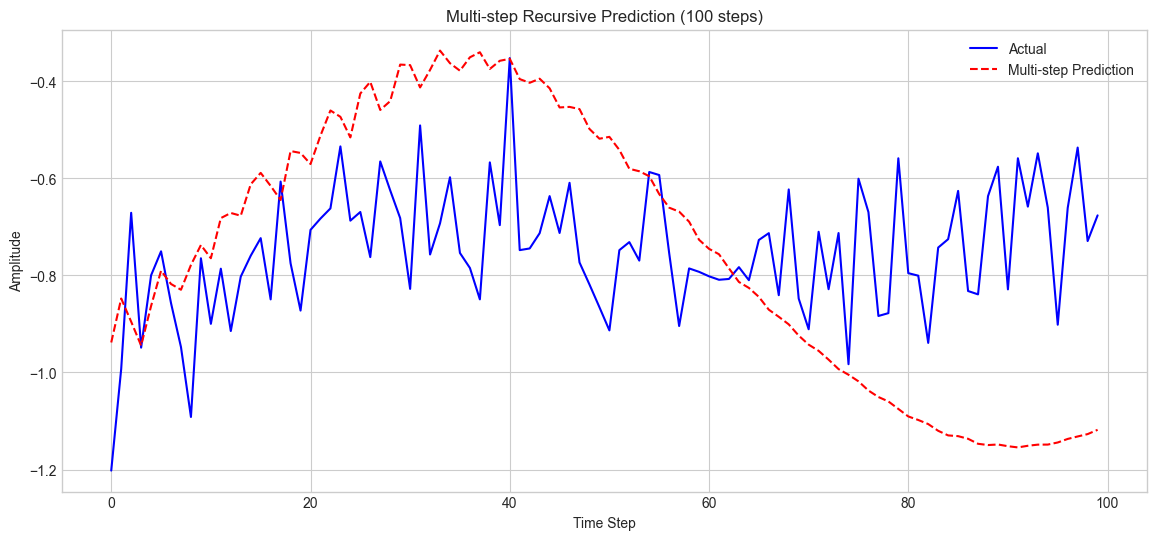

Multi-step R²: -3.8508
Multi-step RMSE: 0.2876


In [17]:
# Train model for recursive multi-step prediction
t, y = generate_complex_waveform(1000, 0.1)
n_lags = 30

X, y_target = create_lag_features(y, n_lags=n_lags)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_target, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
mlp = MLPRegressor(
    hidden_layer_sizes=(200, 100),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42
)
mlp.fit(X_train_scaled, y_train)

# Multi-step prediction
def recursive_predict(model, scaler, initial_sequence, n_steps):
    """Predict multiple steps ahead recursively."""
    predictions = []
    current_seq = initial_sequence.copy()
    
    for _ in range(n_steps):
        # Scale and predict
        x_scaled = scaler.transform(current_seq.reshape(1, -1))
        pred = model.predict(x_scaled)[0]
        predictions.append(pred)
        
        # Update sequence
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = pred
    
    return np.array(predictions)

# Make multi-step predictions
n_predict = 100
initial_seq = X_test[0]
y_multi = recursive_predict(mlp, scaler, initial_seq, n_predict)
y_actual = y_test[:n_predict]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(y_actual, 'b-', linewidth=1.5, label='Actual')
plt.plot(y_multi, 'r--', linewidth=1.5, label='Multi-step Prediction')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.title(f'Multi-step Recursive Prediction ({n_predict} steps)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Multi-step R²: {r2_score(y_actual, y_multi):.4f}")
print(f"Multi-step RMSE: {np.sqrt(mean_squared_error(y_actual, y_multi)):.4f}")

## Part 10: Summary and Best Practices

In [18]:
# ============================================================
# [コードの説明]
# ============================================================

print("Waveform Prediction Best Practices:")
print("="*60)
print()
print("1. FEATURE ENGINEERING")
print("   • Use lag features (past values as predictors)")
print("   • Optimal lag length depends on signal periodicity")
print("   • Consider adding derivative features")
print()
print("2. ARCHITECTURE")
print("   • Start with (100, 50) or (200, 100)")
print("   • Deeper networks for more complex patterns")
print("   • Input size = number of lag features")
print()
print("3. TRAINING")
print("   • Don't shuffle time series data")
print("   • Use early stopping")
print("   • Scale features with StandardScaler")
print()
print("4. EVALUATION")
print("   • Use R², RMSE, MAE")
print("   • Visualize predictions vs actual")
print("   • Check residual distribution")
print()
print("5. MULTI-STEP PREDICTION")
print("   • Recursive: predict one step, feed back")
print("   • Error accumulates with more steps")
print("   • Consider direct multi-output models")

Waveform Prediction Best Practices:

1. FEATURE ENGINEERING
   • Use lag features (past values as predictors)
   • Optimal lag length depends on signal periodicity
   • Consider adding derivative features

2. ARCHITECTURE
   • Start with (100, 50) or (200, 100)
   • Deeper networks for more complex patterns
   • Input size = number of lag features

3. TRAINING
   • Don't shuffle time series data
   • Use early stopping
   • Scale features with StandardScaler

4. EVALUATION
   • Use R², RMSE, MAE
   • Visualize predictions vs actual
   • Check residual distribution

5. MULTI-STEP PREDICTION
   • Recursive: predict one step, feed back
   • Error accumulates with more steps
   • Consider direct multi-output models


## Summary

In this notebook, you learned:

### Waveform Generation
- Complex harmonics, damped oscillations, AM signals, chirps
- Controlling parameters (frequency, amplitude, noise)

### Feature Engineering for Time Series
- Lag features for prediction
- Effect of number of lags on performance

### MLP Regression
- Architecture selection for waveform prediction
- Hyperparameter tuning with GridSearchCV
- Evaluation metrics (R², RMSE, MAE)

### Visualization
- Predicted vs actual waveforms
- Residual analysis
- Multi-step prediction

### Key Takeaways
- Number of lags significantly affects performance
- Larger architectures work better for complex patterns
- Multi-step prediction accumulates error
- Always visualize your predictions!

### Next Steps
Continue to **Notebook 10** for automated hyperparameter tuning techniques!

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

次のノートブックへ

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
